In [38]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tristanVis.isolde as isolde
from tqdm import tqdm

out_dir = "../vault/output_gamma1.020621_TT_0_B_TSI/"#"../sl2urm/output/"
# out_dir = "../sl2urm/output/"

"""
Typical stuff read from the input file
"""
# input_file_name = "../inputs/inputAG.2d_EM_wave_embed"
# input_file_name = "../slurm_scripts/inputAG.2dtwostream_thermal_Bfield_0"
# input_file_name = "../sl2urm/" + "temp_input_gamma1.020621_TT0.in"
input_file_name = out_dir + "temp_input_gamma1.020621_TT0.in"#"temp_input_gamma1.020621_TT0.in"
hist            = isolde.parseHistory(out_dir + "history")
input_params    = isolde.parseInput(input_file_name)
m1              = input_params["particles"]["m1"]
m2              = input_params["particles"]["m2"]
interval        = input_params["output"]["interval"]
lst_time        = input_params["time"]["last"]
grid_x          = int(input_params["grid"]["mx0"])
grid_y          = int(input_params["grid"]["my0"])
Nsteps          = int(lst_time// interval)
CC              = input_params["algorithm"]["c"]
COMP            = input_params["plasma"]["c_omp"]
ppc0            = input_params["plasma"]["ppc0"]
SIGMA           = input_params["plasma"]["sigma"]
B_norm          = CC**2 * SIGMA**0.5 / COMP
omegap0         = CC / COMP
TT              = input_params["problem"]["temperature"]
shift_gamma     = input_params["problem"]["shift_gamma"]
# time            = hist["time"] * omegap0
# B_0             = input_params["problem"]["B_field"]#["B_0"]


def fetch_var_at_step(out_dir, var, step):
    """
    This wrapper function fetches either particle or field data at any output step (!NOT! simulation time step) 
    from an output directory. Obviously.
    """
    filename = out_dir + var + '/' + var + '.tot.%05i'%step
    if var == "prtl":
        return(isolde.getParticles(filename))
    elif var == "flds":
        return(isolde.getFields(filename))
    else:
        print("Not supported yet!")
        return False

# return fetch_var_at_step


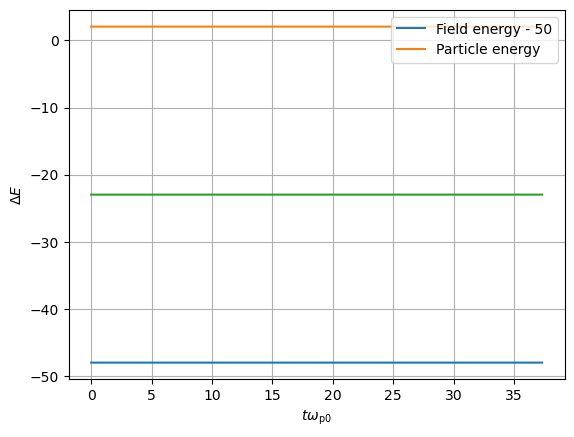

In [3]:
plt.plot(hist["time"] * omegap0, hist['Ex^2'] + hist['Ey^2'] + hist['Ez^2'] + hist['Bx^2'] + hist['By^2'] + hist['Bz^2'] - 47.97,
        label = "Field energy - 50")
plt.plot(hist["time"] * omegap0, 2 * (hist["Esp1"] + hist["Esp2"]), label = "Particle energy")
plt.plot(hist["time"] * omegap0, (2 * (hist["Esp1"] + hist["Esp2"]) + hist['Ex^2'] + hist['Ey^2'] + 
         hist['Ez^2'] + hist['Bx^2'] + hist['By^2'] + hist['Bz^2'] - 47.97)/2 )
# plt.plot(hist["time"] * omegap0, (hist["Etot"] - 47.97)/2, label = "Total energy - 50")
plt.legend()
plt.xlabel(r"$t\omega_{\rm p0}$") 
plt.ylabel(r"$\Delta E$")
plt.grid()

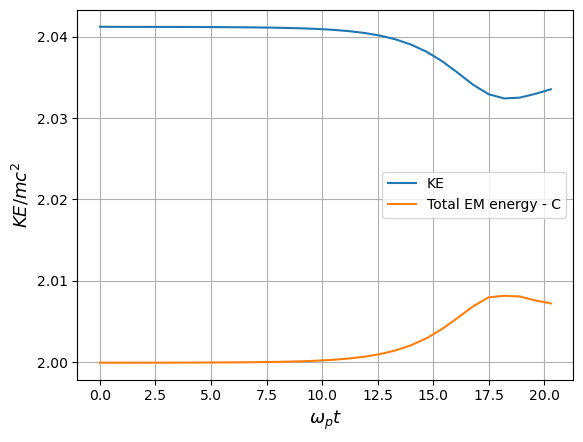

In [270]:
# x_loc = grid_x//2
# delta_x = grid_x
from joblib import Parallel, delayed
frames = np.arange(start = 0, stop = 60, step = 2)

def x_low(frame):
    return 0#int(frame * CC * 1 * np.sqrt(1 - 1/SIGMA) * interval * np.cos(psi) - 500)  #+ 7000)
def x_high(frame):
    return grid_x#int(frame * CC * 1 * np.sqrt(1 - 1/SIGMA) * interval * np.cos(psi) +17000) #+ 8700)
    

# # plt.plot(frames * interval * omegap0, KEs[:,0] + KEs[:,1], label = "KE")
# plt.plot(frames[1:] * interval * omegap0, FEs[1:,0] +  FEs[1:,1] , label = "Total EM energy - C")
# # plt.plot(frames * interval * omegap0, (KEs[:,0] + KEs[:,1]) + (FEs[:,0] + FEs[:,1])* B_norm**2 - 0.029 , label = "Total energy - C")
# # plt.plot(frames * interval * omegap0, FEs[:,0] , label = "E field energy")
# # plt.plot(frames * interval * omegap0, FEs[:,1] , label = r"$B_w$ field energy")
# plt.xlabel(r"$\omega_{p}t$", fontsize = 13)
# plt.ylabel(r"$E$", fontsize = 13)
# plt.legend()
# plt.grid()
# plt.show()

# t_steps = frames[1:] * interval * omegap0

# loss_rate1, _ = np.polyfit(t_steps[:5], tot_E[:5], 1)
# print("Loss rate1 = {}".format(loss_rate1))
# grow_rate2, _ = np.polyfit(t_steps[-20:], tot_E[-20:], 1)
# print("Loss rate1 = {}".format(loss_rate2))
# print("Loss rate_rat = {}".format(loss_rate1/loss_rate2))
weight_fac = 1
m1 = 1
m2 = 1

stride = 10
w_m1 = weight_fac * m1
w_m2 = weight_fac * m2

# def x_low(frame):
#     return 0#int(frame * CC * 1 * np.sqrt(1 - 1/SIGMA) * interval * np.cos(psi) - 500)  #+ 7000)
# def x_high(frame):
#     return grid_x#int(frame * CC * 1 * np.sqrt(1 - 1/SIGMA) * interval * np.cos(psi) +17000) #+ 8700)

def calc_KE(frame):
    
    x_loc = (x_low(frame) + x_high(frame))//2
    delta_x = x_high(frame) - x_low(frame)
    
    # Fetch data for species 1 and species 2
    data_1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]
    data_2 = fetch_var_at_step(out_dir, "prtl", frame)["2"]

    x1, x2 = data_1["x"], data_2["x"]
    mask1 = (x1 > x_loc - delta_x/2) & (x1 < x_loc + delta_x/2)
    mask2 = (x2 > x_loc - delta_x/2) & (x2 < x_loc + delta_x/2)
    
    ux_1, uy_1 = data_1['u'][mask1], data_1['v'][mask1]
    ux_2, uy_2 = data_2['u'][mask2], data_2['v'][mask2]
    
    # # Calculate mod_u directly without creating intermediate arrays
    # mod_u_1 = np.sqrt(ux_1**2 + uy_1**2)
    # mod_u_2 = np.sqrt(ux_2**2 + uy_2**2)

    # # Calculate gamma and kinetic energy directly
    # gamma_1 = 1 / np.abs(np.cos(np.arctan(mod_u_1)))
    # gamma_2 = 1 / np.abs(np.cos(np.arctan(mod_u_2)))
    gamma_1 = np.sqrt(1 + ux_1**2 + uy_1**2)
    gamma_2 = np.sqrt(1 + ux_2**2 + uy_2**2)
    

    # plt.hist(gamma_1)

    # Calculate KE directly without creating intermediate arrays
    KE_1 = np.average((gamma_1 )) *  w_m1 #* stride  / (0.5 * ppc0 * grid_y * (x_high(frame) - x_low(frame)))#/ux_1.shape[0]
    KE_2 = np.average((gamma_2 )) *  w_m2 #* stride  / (0.5 * ppc0 * (grid_y * (x_high(frame) - x_low(frame)))#/ux_2.shape[0]

    # bulk_gamma_1 = 1 / np.abs(np.cos(np.arctan(np.sqrt(np.average(ux_1)**2 + np.average(uy_1)**2))))
    # bulk_gamma_2 = 1 / np.abs(np.cos(np.arctan(np.sqrt(np.average(ux_2)**2 + np.average(uy_2)**2))))

    # bulk_gamma_1 = np.sqrt(1 + np.average(ux_1)**2 + np.average(uy_1)**2)
    # bulk_gamma_2 = np.sqrt(1 + np.average(ux_2)**2 + np.average(uy_2)**2)

    # bulk_KE_1 =  np.sum((bulk_gamma_1 - 1) * m1_CC2)# * ux_1.shape[0]
    # bulk_KE_2 =  np.sum((bulk_gamma_2 - 1) * m2_CC2)# * ux_2.shape[0]

    return (KE_1, KE_2)#, bulk_KE_1, bulk_KE_2)


# calc_KE(400)
# Optimize the computation over multiple frames
# frames = np.arange(start = 0, stop = 350, step = 10)



# KEs = np.array(Parallel(n_jobs=10)(delayed(calc_KE)(frame) for frame in tqdm(frames)))#np.array([calc_KE(frame) for frame in tqdm(frames)])
# KEs = KEs * stride #/ppc0/(grid_x * grid_y)
# KEs = KEs * CC**2

def calc_FE(frame):
    x_loc = (x_low(frame) + x_high(frame))//2
    delta_x = x_high(frame) - x_low(frame)
    
    data_1 = fetch_var_at_step(out_dir, "flds", frame)
    E_field_energy =    np.sum(data_1["ex"][:,:,:]**2 +  data_1["ey"][:,:,:]**2  +  data_1["ez"][:,:,:]**2)* (CC**(-2) * COMP)**2 / (grid_y * grid_x)
    # print(E_field_energy)
    
    Bw_field_energy =   np.sum(data_1["bx"][:,:,:]**2 +  data_1["by"][:,:,:]**2  +  data_1["bz"][:,:,:]**2)* (CC**(-2) * COMP)**2 / (grid_y * grid_x)
    
    return (E_field_energy , Bw_field_energy)

# FEs = np.array(Parallel(n_jobs=10)(delayed(calc_FE)(frame) for frame in tqdm(frames)))#np.array([calc_FE(frame) for frame in tqdm(frames)])#/(grid_x * grid_y)

tot_E = FEs[1:,0] +  FEs[1:,1]


# Plot the result
plt.plot(frames * interval * omegap0, KEs[:,0] + KEs[:,1], label = "KE")
plt.plot(frames[:] * interval * omegap0, FEs[:,0] +  FEs[:,1] - 98 , label = "Total EM energy - C")
# plt.plot(frames * interval * omegap0, KEs[:,2] + KEs[:,3], label = "Bulk KE")
# plt.plot(frames * interval * omegap0, KEs[:,0] + KEs[:,1] - (KEs[:,2] + KEs[:,3]), label = "Thermal KE")
plt.xlabel(r"$\omega_{p}t$", fontsize = 13)
plt.ylabel(r"$KE/mc^2$", fontsize = 13)
plt.grid()
plt.legend()
plt.show()
# t_steps = frames * interval * omegap0
# KE_tot = KEs[:,0] + KEs[:,1]

In [253]:
print(fetch_var_at_step(out_dir, "prtl", 0)["1"]['x'].shape[0] * 10 * 2)
print(ppc0 * grid_x * grid_y)
print(0.5 * (B_norm * CC**(-2) * COMP)**2, SIGMA)

105600000
105600000.0
50.0 100.0


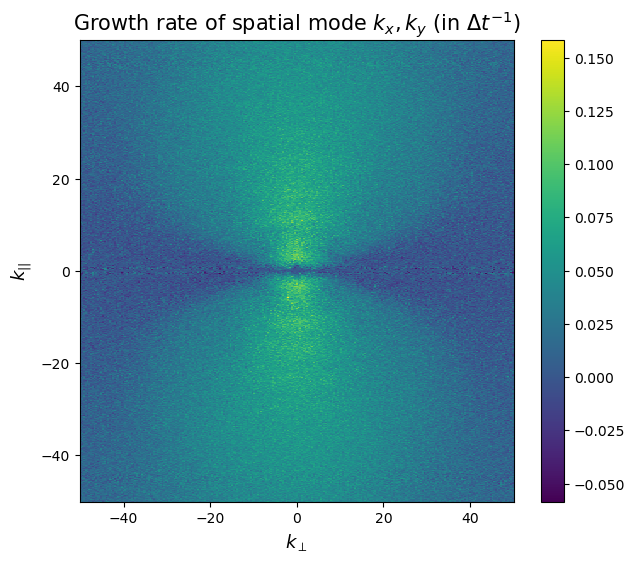

In [101]:
"""
GROWTH RATE USING MODE ANALYSIS AND CURVE FIT
"""


import numpy as np
from tqdm import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import transforms

def collect_subregion_data(out_dir, steps, grid_y, size_x, start_x):
    """
    Collects the charge density data for a selected subregion over all time steps.
    """
    data_region = np.zeros((grid_y, size_x, steps))  # Sub-region shape: grid_y x size_x x Nsteps

    for step in tqdm(range(steps), desc="Fetching data"):
        # Fetch densities for the current step
        dens1 = fetch_var_at_step(out_dir, "flds", step)["dens1"][:, :grid_y, start_x:start_x + size_x]
        dens2 = fetch_var_at_step(out_dir, "flds", step)["dens2"][:, :grid_y, start_x:start_x + size_x]
        
        # Compute charge density
        charge_density = dens1 + dens2  # Assuming dens1 and dens2 are 2D arrays
        
        # Store the charge density in data_region
        data_region[:, :, step] = charge_density

    return data_region

def compute_fft_over_time(data_region):
    """
    Computes the 2D FFT of the charge density data for each time step.
    """
    grid_y, size_x, steps = data_region.shape
    fft_data_all = np.zeros((grid_y, size_x, steps), dtype=complex)

    for step in tqdm(range(steps), desc="Computing FFT"):
        charge_density = data_region[:, :, step]
        
        # Compute the 2D FFT
        fft_data = np.fft.fft2(charge_density)
        
        # Shift the zero frequency component to the center
        fft_shifted = np.fft.fftshift(fft_data)
        
        # Store the FFT data
        fft_data_all[:, :, step] = fft_shifted

    return fft_data_all

def extract_mode_amplitudes(fft_data_all):
    """
    Extracts the amplitude (magnitude) of each mode over time.
    """
    amplitude_data = np.abs(fft_data_all)
    return amplitude_data

def exponential_growth(t, A, gamma):
    return A * np.exp(gamma * t)

def compute_growth_rates(amplitude_data, time_array):
    """
    Computes the growth rates for each mode by fitting amplitude vs. time.
    """
    grid_y, size_x, steps = amplitude_data.shape
    growth_rates = np.zeros((grid_y, size_x))
    log_amplitude = np.log(amplitude_data + 1e-30)  # Avoid log(0)
    
    for i in tqdm(range(grid_y), desc="Computing growth rates"):
        for j in range(size_x):
            y_data = log_amplitude[i, j, :]
            t_data = time_array

            # Fit to linear function since ln(A*exp(gamma*t)) = ln(A) + gamma*t
            def linear_fit(t, lnA, gamma):
                return lnA + gamma * t

            try:
                popt, _ = curve_fit(linear_fit, t_data, y_data)
                growth_rates[i, j] = popt[1]  # Extract gamma
            except RuntimeError:
                growth_rates[i, j] = np.nan  # Fit did not converge

    return growth_rates

def compute_wavenumbers(grid_size, dx):
    """
    Computes the wavenumber arrays for FFT data.
    """
    k = np.fft.fftshift(np.fft.fftfreq(grid_size, d=dx)) * 2 * np.pi
    return k

def plot_growth_rates(growth_rates, kx, ky):
    """
    Plots the growth rates of the modes.
    """
    fig, ax = plt.subplots(figsize=(7, 6))
    tr = transforms.Affine2D().rotate_deg(90)  
    im = ax.pcolormesh(kx, ky, growth_rates, shading='auto', transform=tr + ax.transData)
    fig.colorbar(im)
    ax.set_xlabel(r'$k_\perp$', fontsize = 13)
    ax.set_ylabel(r'$k_{||}$', fontsize = 13)
    ax.set_title(r'Growth rate of spatial mode $k_x, k_y$ (in $\Delta t ^{-1}$)', fontsize = 15)
    ax.set_xlim(-50.1, 50.1)
    ax.set_ylim(-50.1, 50.1)
    
    plt.show()


def find_max_growthrate_in_region(growth_rates, kx, ky, kx_min, kx_max, ky_min, ky_max):
    """
    Finds the maximum growth rate within a specified region of kx and ky.
    
    Parameters:
    - growth_rates: 2D array of growth rates for each mode (k_x, k_y).
    - kx: 1D array of wavenumbers in the x-direction.
    - ky: 1D array of wavenumbers in the y-direction.
    - kx_min, kx_max: Minimum and maximum values of kx for the region.
    - ky_min, ky_max: Minimum and maximum values of ky for the region.
    
    Returns:
    - fastest_mode: tuple of (kx, ky, max_growth_rate) for the fastest-growing mode in the region.
    """
    # Create masks for kx and ky within the desired range
    kx_mask = (kx >= kx_min) & (kx <= kx_max)
    ky_mask = (ky >= ky_min) & (ky <= ky_max)
    
    # Find the indices where kx and ky fall within the desired ranges
    kx_indices = np.where(kx_mask)[0]
    ky_indices = np.where(ky_mask)[0]
    
    # Extract the sub-region of the growth rates
    growth_rates_region = growth_rates[np.ix_(ky_indices, kx_indices)]
    
    # Find the index of the maximum growth rate in the sub-region
    local_max_idx = np.unravel_index(np.argmax(growth_rates_region, axis=None), growth_rates_region.shape)
    
    # Map back to the global indices
    global_max_idx = (ky_indices[local_max_idx[0]], kx_indices[local_max_idx[1]])
    
    # Extract the corresponding kx, ky, and maximum growth rate
    kx_fastest = kx[global_max_idx[1]]
    ky_fastest = ky[global_max_idx[0]]
    max_growth_rate = growth_rates[global_max_idx]
    
    return kx_fastest, ky_fastest, max_growth_rate

# # Step 1: Collect Data
# data_region = collect_subregion_data(out_dir, Nsteps, grid_y, grid_x, 0)
# time_array = np.arange(0, Nsteps, 1)
# # Step 2: Compute 2D FFT
# fft_data_all = compute_fft_over_time(data_region)

# # Step 3: Extract Mode Amplitudes
# amplitude_data = extract_mode_amplitudes(fft_data_all)

# # Step 4: Compute Growth Rates
# growth_rates = compute_growth_rates(amplitude_data, time_array)/interval

# Step 5: Plot Growth Rates

# Compute Wavenumbers
kx = compute_wavenumbers(grid_x, dx = 1/COMP)
ky = compute_wavenumbers(grid_y, dx = 1/COMP)
# growth_rates = growth_rates / interval
plot_growth_rates(growth_rates, kx, ky)
# plt.plot(amplitude_data[600, 20, :])

100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.98s/it]


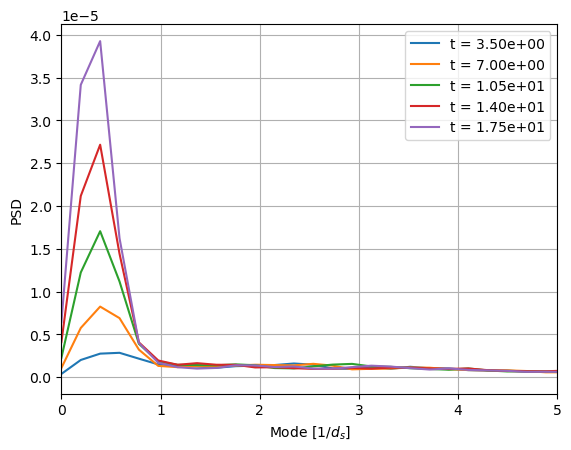

In [109]:
from scipy import signal

fs = COMP #COMP / np.sqrt(weight_fac)  # Calculate sampling frequency
weight_fac = 1
fig, ax = plt.subplots()

def x_low(frame):
    return 0 #int(frame * CC * 1 * np.sqrt(1 - 1/SIGMA) * interval * np.cos(psi) + 7000)
def x_high(frame):
    return -1 #int(frame * CC * 1 * np.sqrt(1 - 1/SIGMA) * interval * np.cos(psi) + 8700)

def PSD(frame):
    data = np.average(fetch_var_at_step(out_dir, "flds", frame)["dens1"][:,:,:], axis = (0, 1))[x_low(frame):x_high(frame)]
    data = data / (ppc0 * weight_fac)
    f, Pxx = signal.welch(data, fs)
    return f, Pxx

for frame in tqdm(range(10, 60, 10)):    
    f, Pxx = PSD(frame)
    ax.plot(f, Pxx, label = r"t = {:.2e}".format(frame * interval * omegap0))

# data = np.average(fetch_var_at_step(out_dir, "flds", 15)["dens1"][:,:,:], axis = 0)[0]
# f, Pxx = signal.welch(data, fs)
# ax.plot(f, Pxx, label = r"t = {:.2e}".format(15 * interval))

# data = np.average(fetch_var_at_step(out_dir, "flds", 20)["dens1"][:,:,:], axis = 0)[0]
# f, Pxx = signal.welch(data, fs)
# ax.plot(f, Pxx, label = r"t = {:.2e}".format(20 * interval))

# data = np.average(fetch_var_at_step(out_dir, "flds", 25)["dens1"][:,:,:], axis = 0)[0]
# f, Pxx = signal.welch(data, fs)
# ax.plot(f, Pxx, label = r"t = {:.2e}".format(25 * interval))

# data = np.average(fetch_var_at_step(out_dir, "flds", 30)["dens1"][:,:,:], axis = 0)[0]
# f, Pxx = signal.welch(data, fs)
# ax.plot(f, Pxx, label = r"t = {:.2e}".format(30 * interval))

# data = np.average(fetch_var_at_step(out_dir, "flds", 35)["dens1"][:,:,:], axis = 0)[0]
# f, Pxx = signal.welch(data, fs)
# ax.plot(f, Pxx, label = r"t = {:.2e}".format(35 * interval))

ax.set_xlabel(r'Mode [$1/d_s$]')
ax.set_xlim(0, 5)
ax.set_ylabel('PSD')
ax.grid()
ax.legend()
plt.show()



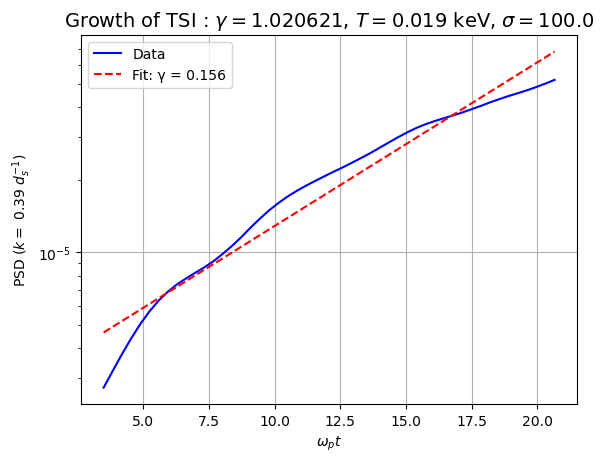

In [113]:
fs = COMP #COMP/ np.sqrt(weight_fac)

# data = np.average(fetch_var_at_step(out_dir, "flds", 30)["dens1"][:,:,:], axis = 0)[0]
f, Pxx = PSD(frame = 40) #signal.welch(data, fs)

# To find the dominant peak (highest amplitude)
dominant_peak_idx = np.argmax(Pxx) 

# PSD_peak_val = []
# time_stamps = []
# for i in tqdm(range(10, 60)):
#     # data = np.average(fetch_var_at_step(out_dir, "flds", i)["dens1"][:,:,:], axis = 0)[0]
#     f, Pxx = PSD(i)#signal.welch(data, fs)
#     PSD_peak_val.append(Pxx[dominant_peak_idx])
#     time_stamps.append(i * interval * omegap0)

# # fig, ax = plt.subplots()
# # ax.plot(time_stamps, PSD_peak_val)
# # ax.grid()
# # ax.set_xlabel(r"$\omega_{p0} t$")
# # ax.set_ylabel(r"PSD ($k =$ {:.2f}".format(f[dominant_peak_idx]) + r" $d_s^{-1}$)")


time_stamps = np.array(time_stamps)
PSD_peak_val = np.array(PSD_peak_val)

# print(PSD_peak_val)

# Take log of PSD values for linear fit
log_PSD = np.log(PSD_peak_val)

# Fit a line to the log data
coeffs = np.polyfit(time_stamps[:], log_PSD[:], 1)
growth_rate = coeffs[0]  # This is your growth rate

# Generate fitted curve
fit_curve = np.exp(coeffs[1]) * np.exp(growth_rate * time_stamps)

# Your existing plotting code with added fit line
fig, ax = plt.subplots()
ax.plot(time_stamps, PSD_peak_val, 'b-', label='Data')
ax.plot(time_stamps[:], fit_curve[:], 'r--', label=f'Fit: γ = {growth_rate:.3f}')
ax.grid()
ax.set_xlabel(r"$\omega_{p} t$")
ax.set_ylabel(r"PSD ($k =$ {:.2f}".format(f[dominant_peak_idx]) + r" $d_s^{-1}$)")
ax.legend()
ax.set_title(r"Growth of TSI : $\gamma = {0}$, $T = {1}$ keV, $\sigma = {2}$".format(shift_gamma, TT, SIGMA),
            fontsize = 14)
# Optional: set y-axis to log scale to better see exponential behavior
ax.set_yscale('log')
# plt.savefig(r"Growth of TSI : wA_wp = {0}$, psi = {1}, n_0 = {2}n_c, sigma = {3}.png".format(wA_wp, psi, mult1, SIGMA),dpi = 400)
plt.show()

In [36]:
size_x = 4400  # Size of the subregion in x-direction
start_x = 0  # Starting x index
dx = 1  # Spatial resolution in x-direction
dy = 1  # Spatial resolution in y-direction
total_time = 100  # Total simulation time
time_array = np.arange(0, total_time, 1)
steps = time_array.size
shift_gammas = []
maxkxs=[]
gws=[]
maxkys=[]

for counter in range(6):

    out_dir = "../vault/output{}/".format("ABCDEF"[counter])
    input_file_name = "../slurm_scripts/inputAG.2dtwostream_thermal_Bfield_{}".format(counter)
    input_params    = isolde.parseInput(input_file_name)
    shift_gammas.append(input_params["problem"]["shift_gamma"])
    
    # Step 1: Collect Data
    data_region = collect_subregion_data(out_dir, steps, 400, size_x, start_x)
    
    # Step 2: Compute 2D FFT
    fft_data_all = compute_fft_over_time(data_region)
    
    # Step 3: Extract Mode Amplitudes
    amplitude_data = extract_mode_amplitudes(fft_data_all)
    
    # Step 4: Compute Growth Rates
    growth_rates = compute_growth_rates(amplitude_data, time_array)/interval
    
    # Step 5: Plot Growth Rates
    
    # Compute Wavenumbers
    kx = compute_wavenumbers(size_x, dx)
    ky = compute_wavenumbers(400, dy)
    
    # plot_growth_rates(growth_rates, kx, ky)
    # Example usage:
    kx_fastest, ky_fastest, max_growth_rate = find_max_growthrate_in_region(growth_rates, kx, ky, -2.5, 2.5, -2.5, 2.5)
    print(f"Fastest Growing Mode: kx = {kx_fastest}, ky = {ky_fastest}, growth rate = {max_growth_rate}")
    maxkxs.append(kx_fastest)
    maxkys.append(ky_fastest)
    gws.append(max_growth_rate)
    print("lengthscale = {}".format(np.abs(2*np.pi/kx_fastest)))

Computing growth rates: 100%|██████████████████████████████████████████████████████| 400/400 [10:13<00:00,  1.53s/it]


Fastest Growing Mode: kx = 1.2566370614359172, ky = -0.047123889803846894, growth rate = 0.004636728968214964
lengthscale = 5.0


Computing growth rates: 100%|██████████████████████████████████████████████████████| 400/400 [09:39<00:00,  1.45s/it]


Fastest Growing Mode: kx = -1.2566370614359172, ky = 0.23561944901923448, growth rate = 0.0045197404254588795
lengthscale = 5.0


Computing growth rates: 100%|██████████████████████████████████████████████████████| 400/400 [09:44<00:00,  1.46s/it]


Fastest Growing Mode: kx = -1.2566370614359172, ky = 0.26703537555513246, growth rate = 0.004605136222650938
lengthscale = 5.0


Computing growth rates: 100%|██████████████████████████████████████████████████████| 400/400 [09:52<00:00,  1.48s/it]


Fastest Growing Mode: kx = 1.2566370614359172, ky = -0.07853981633974483, growth rate = 0.004703441069315269
lengthscale = 5.0


Computing growth rates: 100%|██████████████████████████████████████████████████████| 400/400 [09:43<00:00,  1.46s/it]


Fastest Growing Mode: kx = 1.2566370614359172, ky = 0.047123889803846894, growth rate = 0.004498906825378457
lengthscale = 5.0


Computing growth rates: 100%|██████████████████████████████████████████████████████| 400/400 [09:54<00:00,  1.49s/it]

Fastest Growing Mode: kx = -1.2566370614359172, ky = -0.015707963267948967, growth rate = 0.004529895309809318
lengthscale = 5.0


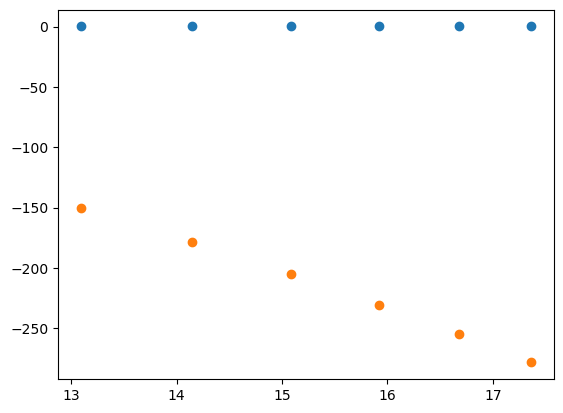

In [43]:
shift_gammas = np.array(shift_gammas)
gws = np.array(gws)
maxkxs = np.array(maxkxs)
maxkys = np.array(maxkys)

betas = np.sqrt(1 - 1/shift_gammas**2)
input_file_name = "../slurm_scripts/inputAG.2dtwostream_thermal_Bfield_{}".format(0)
input_params    = isolde.parseInput(input_file_name)
CC              = input_params["algorithm"]["c"]
COMP            = input_params["plasma"]["c_omp"]
ppc0            = input_params["plasma"]["ppc0"]
SIGMA           = input_params["plasma"]["sigma"]
B_norm          = CC**2 * SIGMA**0.5 / COMP
omegap0         = CC / COMP

g_rate_norm = gws/omegap0
maxkx_norm = maxkxs * COMP
maxky_norm = maxkys * COMP

# mask = (maxky_norm == 0)

# shift_gammas_filt = shift_gammas#[mask]
# betas_filt = betas#[mask]
# maxkx_norm_filt = maxkx_norm[mask]
# g_rate_norm_filt = g_rate_norm[mask]

# Cfac = 1/shift_gammas_filt**4
# omega_beta = np.abs(betas_filt * maxkx_norm_filt)

# g_theo = np.sqrt(np.sqrt(4 * Cfac * omega_beta**2 + Cfac**2) - Cfac - omega_beta**2)

# plt.scatter(omega_beta, g_rate_norm_filt)
# plt.scatter(omega_beta, g_theo)

Cfac = (maxkx_norm**2 / (maxkx_norm**2 + maxky_norm**2 )) * 1/shift_gammas**4
omega_beta = np.abs(betas * maxkx_norm)

g_theo_2 = np.sqrt(4 * Cfac * omega_beta**2 + Cfac**2) - Cfac - omega_beta**2

plt.scatter(omega_beta, g_rate_norm**2)
plt.scatter(omega_beta, g_theo_2)

In [41]:
print(shift_gammas)
print(betas)
print(maxkx_norm)
print(omega_beta)
print(Cfac)

[1.1  1.2  1.12 1.14 1.16 1.18]
[0.41659779 0.5527708  0.45034001 0.48013797 0.50679098 0.53086304]
[ 31.41592654 -31.41592654 -31.41592654  31.41592654  31.41592654
 -31.41592654]
[13.08780558 17.36580679 14.1478486  15.08397923 15.92130824 16.67755435]
[0.68205432 0.46587468 0.60806035 0.58977646 0.55151553 0.5157083 ]


In [183]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import fftpack
from scipy.signal import windows  # For window functions

def calculate_2d_psd(image_data, dx, dy, window=True):
    """
    Calculate the 2D power spectrum density of an image with physical units.
    
    Parameters:
    -----------
    image_data : 2D numpy array
        The input image data
    dx, dy : float
        Physical size of each grid cell in x and y directions
    window : bool, optional
        Apply Hann window to reduce edge effects (default: True)
    
    Returns:
    --------
    k_x, k_y : 2D numpy arrays
        Wavenumber grids in x and y directions
    psd_2d : 2D numpy array
        The 2D power spectrum density
    """
    # Get dimensions
    ny, nx = image_data.shape
    
    # Apply window function to reduce edge effects
    if window:
        window_x = windows.hann(nx)  # Using scipy.signal.windows.hann
        window_y = windows.hann(ny)
        window_2d = np.outer(window_y, window_x)
        windowed_data = image_data * window_2d
    else:
        windowed_data = image_data
    
    # Compute the 2D FFT
    fft_data = fftpack.fft2(windowed_data)
    
    # Shift the zero frequency to the center
    fft_shifted = fftpack.fftshift(fft_data)
    
    # Calculate the PSD (power spectrum density)
    psd_2d = np.abs(fft_shifted)**2
    
    # Normalize by the number of elements and physical grid size
    psd_2d = psd_2d / (nx * ny * dx * dy)
    
    # Calculate the frequency grids with physical units
    # The frequency step is the reciprocal of the domain size
    df_x = 1.0 / (nx * dx)
    df_y = 1.0 / (ny * dy)
    
    # Create frequency grid centered at zero
    f_x = fftpack.fftshift(fftpack.fftfreq(nx, d=dx))
    f_y = fftpack.fftshift(fftpack.fftfreq(ny, d=dy))
    
    # Convert to wavenumber (k = 2π/λ = 2πf)
    k_x, k_y = np.meshgrid(2 * np.pi * f_x, 2 * np.pi * f_y)
    
    return k_x, k_y, psd_2d



def plot_2d_psd(k_x, k_y, psd_2d, k_limits=None, k_units="1/cm", log_scale=True, 
                title="2D Power Spectrum Density", save_path=None):
    """
    Plot the 2D power spectrum density using contourf with restricted k-range.
    
    Parameters:
    -----------
    k_x, k_y : 2D numpy arrays
        Wavenumber grids in x and y directions
    psd_2d : 2D numpy array
        The 2D power spectrum density
    k_limits : tuple, optional
        Limits for both axes in the form (k_min, k_max). If None, use data limits.
    k_units : str, optional
        Units for the wavenumbers (default: "1/cm")
    log_scale : bool, optional
        Use logarithmic color scale (default: True)
    title : str, optional
        Plot title
    save_path : str, optional
        Path to save the figure (if None, figure is not saved)
    """
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Extract 1D wavenumber arrays
    k_x_1d = k_x[0, :]  # Length nx, varies with f_x
    k_y_1d = k_y[:, 0]  # Length ny, varies with f_y
    
    # Transpose psd_2d to match desired axis order (k_y on x-axis, k_x on y-axis)
    psd_2d_transposed = psd_2d.T  # Shape (nx, ny)
    
    # Apply mask if k_limits is specified
    if k_limits is not None:
        k_min, k_max = k_limits
        # Create 1D masks for k_x and k_y
        mask_x = (k_x_1d >= k_min) & (k_x_1d <= k_max)  # Length nx
        mask_y = (k_y_1d >= k_min) & (k_y_1d <= k_max)  # Length ny
        # Create 2D mask with shape (nx, ny)
        mask = np.outer(mask_x, mask_y)
        psd_masked = np.copy(psd_2d_transposed)
        # Set values OUTSIDE the range to NaN
        psd_masked[~mask] = np.nan
    else:
        psd_masked = psd_2d_transposed
        k_min = min(k_y_1d.min(), k_x_1d.min())
        k_max = max(k_y_1d.max(), k_x_1d.max())
    
    # Set levels for contourf
    if log_scale:
        psd_min = np.nanmin(psd_masked[psd_masked > 0])
        psd_max = np.nanmax(psd_masked)
        levels = np.logspace(0, np.log10(psd_max), 50)
        norm = LogNorm(vmin=1, vmax=psd_max)
    else:
        psd_min = np.nanmin(psd_masked)
        psd_max = np.nanmax(psd_masked)
        levels = np.linspace(psd_min, psd_max, 50)
        norm = None
    
    # Create the contour plot (k_y on x-axis, k_x on y-axis)
    contour = ax.contourf(k_y_1d, k_x_1d, psd_masked, levels=levels, norm=norm, cmap='hot')
    
    # Add colorbar
    cb = fig.colorbar(contour)
    cb.set_label('PSD', fontsize=14)
    cb.ax.tick_params(labelsize=13)
    
    if log_scale:
        min_exp = 0 #np.ceil(np.log10(psd_min))
        max_exp = np.floor(np.log10(psd_max))
        ticks = 10 ** np.arange(min_exp, max_exp + 1)
        cb.set_ticks(ticks)
        cb.set_ticklabels([f'$10^{{{int(exp)}}}$' for exp in np.arange(min_exp, max_exp + 1)])
   
    
    # Set labels and title
    ax.set_xlabel(r'$k_{\perp}$' + f'({k_units})', fontsize=13)
    ax.set_ylabel(r'$k_{||}$' + f'({k_units})', fontsize=13)
    ax.set_title(title, fontsize=15)
    
    # Set tick font size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add circles for constant |k| values
    for k_radius in np.linspace(0, k_max, 5)[1:]:
        circle = plt.Circle((0, 0), k_radius, fill=False, color='black', linestyle='--', alpha=0.7)
        plt.gca().add_patch(circle)
    
    # plt.axis('equal')
    plt.tight_layout()

    ax.set_xlim(k_min, k_max)
    ax.set_ylim(k_min, k_max)
    ax.tick_params(axis='both', which='major', labelsize=12)
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    plt.show()




  0%|                                                                                           | 0/280 [00:00<?, ?it/s]

  0%|▎                                                                                  | 1/280 [00:00<04:31,  1.03it/s]

  1%|▌                                                                                  | 2/280 [00:02<05:40,  1.22s/it]

  1%|▉                                                                                  | 3/280 [00:03<05:57,  1.29s/it]

  1%|█▏                                                                                 | 4/280 [00:05<06:06,  1.33s/it]

  2%|█▍                                                                                 | 5/280 [00:06<05:59,  1.31s/it]

  2%|█▊                                                                                 | 6/280 [00:07<05:46,  1.27s/it]

  2%|██                                                                                 | 7/280 [00:08<05:52,  1.29s/it]

  3%|██▎              

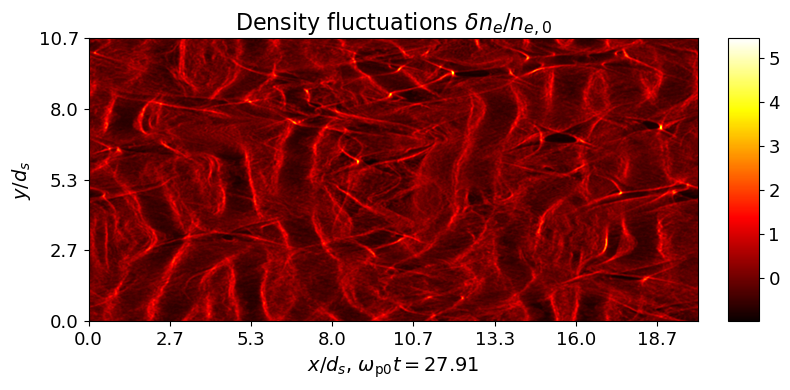

In [44]:
"""
ANIMATION: Make sure to "fetch" the appropriate data first.
###########################################################

This code here is optimised for animating a scalar field faster, here density fluctuations.
"""

from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 12))
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]
fig.set_tight_layout(True)
# ax1.set_title(r"charge density $=|e^-| (n_{e^+}-n_{e^-})$")
ax1.set_title(r"Density fluctuations $\delta n_e/ n_{e,0}$",fontsize=16)
# ax1.set_title(r"$j_{||}/B_0 (x,y) $ ")


div = make_axes_locatable(ax1)
cax = div.append_axes('right', '5%', '5%')

d1_0 = np.average(fetch_var_at_step(out_dir, "flds", 0)["dens1"][:,:,:], axis = 0)#/B_norm
d2_0 = np.average(fetch_var_at_step(out_dir, "flds", 0)["dens2"][:,:,:], axis = 0)#/B_norm

def arr_func(step):
    d1 = np.average(fetch_var_at_step(out_dir, "flds", step)["dens1"][:,:,:], axis = 0)#/B_norm
    d2 = np.average(fetch_var_at_step(out_dir, "flds", step)["dens2"][:,:,:], axis = 0)#/B_norm
    e_fiducial = CC**2/(ppc0 * COMP**2)
    d_fluc = (d1 + d2 - d1_0 -  d2_0)/(d1_0 + d2_0)
    return  d_fluc[:, :] #jx * np.cos(psi) + jy * np.sin(psi) #Ex[step,:,:]*np.cos(psi) + Ey[step,:,:]*np.sin(psi) #density1[step, : , : ] - density2[step, : , : ]

im = ax1.imshow(arr_func(0), origin='lower', aspect = 'auto', cmap = 'hot') 
cb = fig.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=13)
tx = ax1.set_xlabel(r"$x / d_s$", fontsize = 14)
ax1.set_ylabel(r"$y / d_s$", fontsize = 14)

# Change only ax2
scale_x = CC / omegap0
scale_y = CC / omegap0
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:.1f}'.format(x/scale_x))
ax1.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:.1f}'.format(x/scale_y))
ax1.yaxis.set_major_formatter(ticks_y)

ax1.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax1.tick_params(axis='both', which='major', labelsize=13)

# ax1.annotate(r"$B_0$",
#             xytext=(50, 50), xycoords='data',  # Head of the arrow
#             xy=(50 + 250, 50 + int(np.tan(psi) * 250)), textcoords='data',  # Tail of the arrow
#             arrowprops=dict(arrowstyle="->", lw=3)  # Arrow style and properties
#             )

ax1.set_xlim(0, 1500)
ax1.set_ylim(0, 800)
track_pulse = False

# Function to update the frame
def animate_scalar(frame):
    arr = arr_func(frame)
    vmax     = np.max(arr)
    vmin     = np.min(arr)
    im.set_data(arr)
    im.set_clim(vmin, vmax)
    # tx.set_text(r"x-axis, $2\pi f t$ = " + "{:.2f}".format(frame * interval * freq * 2*np.pi))
    tx.set_text(r"$x/d_s$, $\omega_{\rm p0}t = $" + "{:.2f}".format(frame * interval * omegap0))
    # fig.tight_layout()

# Create the animation
ani = FuncAnimation(fig, animate_scalar, frames=tqdm(range(20, 300)), blit=False)

# # Save the animation
writer = FFMpegWriter(fps=20, bitrate=-1)
ani.save("./ch_dens(x,y)_B_TSI_gamma={:.3f}, TT={:.2E}.mp4".format(shift_gamma, TT), 
         writer=writer, dpi=400)
# animate_scalar(frame = 20)
plt.show()

# k_x, k_y, psd_2d = calculate_2d_psd(arr_func(50)[:,:], dx = 1/COMP, dy = 1/COMP, window = True)
# plot_2d_psd(k_x, k_y ,psd_2d, k_limits=(-40, 40), k_units=r"$1/d_s$", log_scale=True)
# plt.show()


In [11]:
print(Nsteps)

400


In [ ]:
delta_d1 = np.array([np.std(fetch_var_at_step(out_dir, "flds", frame)["dens1"][0,:400,:5000]) for frame in tqdm(range(250))])
delta_d2 = np.array([np.std(fetch_var_at_step(out_dir, "flds", frame)["dens2"][0,:400,:5000]) for frame in tqdm(range(250))])

mean_d1  = np.mean(fetch_var_at_step(out_dir, "flds", 0)["dens1"][0,:,:])
mean_d2  = np.mean(fetch_var_at_step(out_dir, "flds", 0)["dens2"][0,:,:])

T =np.arange(delta_d1.shape[0]) * interval * omegap0
fig, ax = plt.subplots()
ax.plot(T, delta_d1/mean_d1, label = "electron (+x)")
ax.plot(T, delta_d2/mean_d2, label = "electron (-x)")
ax.set_title(r"$\delta n / <n>$ for $e^{-}$ counter-streams")
ax.set_xlabel(r"$t\omega_{\rm p0}$")
# ax.set_xlim(0, 24)
# ax.set_ylabel(r"$U_E / E_{\rm tot}$")
plt.legend()

In [ ]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]
# Function to update the frame
def animate_ampere(frame):
    # ex_1         = np.average(fetch_var_at_step(out_dir, "flds", frame-1)["ex"][:,:,:], axis = 0)/B_norm
    # ey_1         = np.average(fetch_var_at_step(out_dir, "flds", frame-1)["ey"][:,:,:], axis = 0)/B_norm
    # ex_2         = np.average(fetch_var_at_step(out_dir, "flds", frame+1)["ex"][:,:,:], axis = 0)/B_norm
    # ey_2         = np.average(fetch_var_at_step(out_dir, "flds", frame+1)["ey"][:,:,:], axis = 0)/B_norm
    # del_t_ex     = (ex_2 - ex_1)/(2*interval)
    # del_t_ey     = (ey_2 - ey_1)/(2*interval)
    
    jx           = np.average(fetch_var_at_step(out_dir, "flds", frame)["jx"][:,:,:], axis = 0)/B_norm
    jy           = np.average(fetch_var_at_step(out_dir, "flds", frame)["jy"][:,:,:], axis = 0)/B_norm
    
    bz           = np.average(fetch_var_at_step(out_dir, "flds", frame)["bz"][:,:,:], axis = 0)/B_norm
    del_x_bz     = np.gradient(bz, axis = 1)
    del_y_bz     = np.gradient(bz, axis = 0)

    curl_b_parr  = np.average(del_y_bz * np.cos(psi) - del_x_bz * np.sin(psi), axis = 0)
    # del_t_e_parr = np.average(del_t_ex * np.cos(psi) + del_t_ey * np.sin(psi), axis = 0)
    j_parr       = np.average(      jx * np.cos(psi) +       jy * np.sin(psi), axis = 0)
    
    ax1.clear()
    
    ax1.plot(xx, curl_b_parr*CC                         ,color = "red"  , linewidth = 0.9, label = r"$\nabla \times B_{||}$")
    ax1.plot(xx, j_parr                                 ,color = "blue" , linewidth = 0.9, label = r"$j_{||}$")
    # ax1.plot(xx, del_t_e_parr                           ,color = "green", linewidth = 0.9, label = r"$\partial_t E_{||}$")
    # ax1.plot(xx, curl_b_parr*CC - j_parr - del_t_e_parr ,color = "black", linewidth = 0.7, label = "Ampere's law validity")
    ax1.legend()    
    ax1.set_xlim(0,  grid_x/3)
    ax1.set_xlabel(r"$x-axis$")
    ax1.set_ylabel(r"Ampere's law terms (scale = $B_0$)")
    ax1.text(0, 0, r"$t$ = " + "{:.2f}".format(frame * interval), fontsize=10, transform=ax1.transAxes)
    ax1.legend(loc="lower right")

    ax2.clear()
    
    ax2.plot(xx, curl_b_parr*CC                         ,color = "red"  , linewidth = 0.9, label = r"$\nabla \times B_{||}$")
    ax2.plot(xx, j_parr                                 ,color = "blue" , linewidth = 0.9, label = r"$j_{||}$")
    # ax2.plot(xx, del_t_e_parr                           ,color = "green", linewidth = 0.9, label = r"$\partial_t E_{||}$")
    # ax2.plot(xx, curl_b_parr*CC - j_parr - del_t_e_parr ,color = "black", linewidth = 0.7, label = "Ampere's law validity")
    ax2.legend()
    ax2.set_xlim(grid_x/3, 2 * grid_x/3)
    ax2.set_xlabel(r"$x-axis$")
    ax2.set_ylabel(r"Ampere's law terms (scale = $B_0$)")
    ax2.text(0, 0, r"$t$ = " + "{:.2f}".format(frame * interval ), fontsize=10, transform=ax1.transAxes)
    ax2.legend(loc="lower right")

    ax3.clear()
    
    ax3.plot(xx, curl_b_parr*CC                         ,color = "red"  , linewidth = 0.9, label = r"$\nabla \times B_{||}$")
    ax3.plot(xx, j_parr                                 ,color = "blue" , linewidth = 0.9, label = r"$j_{||}$")
    # ax3.plot(xx, del_t_e_parr                           ,color = "green", linewidth = 0.9, label = r"$\partial_t E_{||}$")
    # ax3.plot(xx, curl_b_parr*CC - j_parr - del_t_e_parr ,color = "black", linewidth = 0.7, label = "Ampere's law validity")
    ax3.legend()
    ax3.set_xlim( 2 * grid_x/3, grid_x)
    ax3.set_xlabel(r"$x-axis$")
    ax3.set_ylabel(r"Ampere's law terms (scale = $B_0$)")
    ax3.text(0, 0, r"$t$ = " + "{:.2f}".format(frame * interval ), fontsize=10, transform=ax1.transAxes)
    ax3.legend(loc="lower right")
    return ax1.get_children() + ax2.get_children() + ax3.get_children()  # Return a list of Artists

# # Create the animation
# ani = FuncAnimation(fig, animate_particle, frames=tqdm(range(Nsteps-1)), blit=False)

# # Save the animation
# writer = FFMpegWriter(fps=15, bitrate=2400)
# ani.save("../vault_out/Wave_sourced_v2/Ampere(x)_PARAMS_B_amp_plasma_{}_vlim = {:.2f}, freq = {:.2f}, duration = {:.1f}, angle = {:.2f}.mp4".format(run_no, B_amp, freq, duration, psi), 
#          writer=writer, dpi=400)

animate_ampere(60)
plt.show()

In [ ]:
"""
ANIMATION: Make sure to "fetch" the appropriate data first.
###########################################################

This code here is optimised for animating a scalar field faster
"""

from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]

#ax.set_title(r"Charge density $=|e^-| (n_{e^+}-n_{e^-})$")
ax1.set_title(r"$E_{||} (x,y) $ ")
div = make_axes_locatable(ax1)
cax = div.append_axes('right', '5%', '5%')

def arr_func(step):
    return Ex[step,:,:]*np.cos(psi) + Ey[step,:,:]*np.sin(psi)#density1[step, : , : ] - density2[step, : , : ]

im = ax1.imshow(arr_func(0), origin='lower', aspect = 'auto') 
cb = fig.colorbar(im, cax=cax)
tx = ax1.set_xlabel("x-axis")
ax1.set_ylabel("y-axis")


# Function to update the frame
def animate_scalar(frame):
    arr = arr_func(frame)
    vmax     = np.max(arr)
    vmin     = np.min(arr)
    im.set_data(arr)
    im.set_clim(vmin, vmax)
    tx.set_text(r"x-axis, $2\pi f t$ = " + "{:.2f}".format(frame * interval * freq * 2*np.pi)) 

    ax2.clear()
    ax2.plot(xx, Bz[frame, 0, :])   
    ax2.set_ylim(0, 0.3)
    ax2.set_xlabel(r"x-axis, $2\pi f t$ = " + "{:.2f}".format(frame * interval * freq * 2*np.pi))    
    ax2.set_ylabel(r"$B_z(x)$")
    return ax2.get_children()
# Create the animation
ani = FuncAnimation(fig, animate_scalar, frames=tqdm(range(Nsteps)), blit=False)

# Save the animation
writer = FFMpegWriter(fps=15, bitrate=2400)
ani.save("../vault_out/Wave_embed/E_par(x,y)_PARAMS_B_amp_plasma_19 = {:.2f}, freq = {:.2f}, duration = {:.1f}, angle = {:.2f}.mp4".format(B_amp, freq, duration, psi), 
         writer=writer, dpi=400)

plt.show()


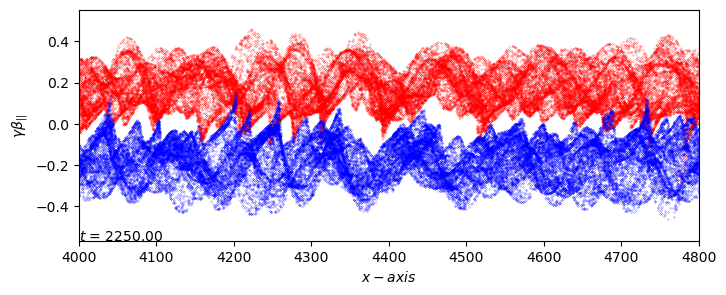

In [69]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

fig, ax1 = plt.subplots(1, 1, figsize=(8, 3))
xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]
# Function to update the frame
def animate_particle(frame):
    ax1.clear()
    
    x1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]['x']
    ux_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['u']
    # y1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['y']
    # uy_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['v']

    x2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['x']
    ux_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['u']
    # y2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['y']
    # uy_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['v']
    stride = 10
    ax1.scatter(x1[: : stride], ux_1[: : stride], s = 0.03, color = "red", label="positrons")
    ax1.scatter(x2[: : stride], ux_2[: : stride], s = 0.03, color = "blue", label="electrons")
    # ax1.set_ylim(-0.25, 0.25)
    ax1.set_xlim(4000, 4800)
    ax1.set_xlabel(r"$x-axis$")
    ax1.set_ylabel(r"$\gamma \beta_{||}$")
    ax1.text(0, 0, "$t$ = " + "{:.2f}".format(frame * interval), fontsize=10, transform=ax1.transAxes)
    # ax1.legend(loc="lower right")

    
    return ax1.get_children() # + ax2.get_children()#ax1.lines + [ax1.texts[-1]]  # Return a list of Artists

# # Create the animation
# ani = FuncAnimation(fig, animate_particle, frames=tqdm(range(300)), blit=False)

# # Save the animation
# writer = FFMpegWriter(fps=15, bitrate=2400)
# ani.save("./phase3(x,y)_PARAMS_B_amp_plasma_{}= {:.2f}, mode = {:.3f}, angle = {:.2f}.mp4".format(run_no, B_amp, mode, psi), 
#          writer=writer, dpi=400)
# plt.show
animate_particle(frame = 45)
plt.show()

In [ ]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
fig, ax = plt.subplots()


temp = 100

# Function to update the frame
# def animate_phase(frame):
#     ax.clear()
#     # ax.scatter(0, -0.2)
#     # ax.scatter(0, 0.2)
#     ax.scatter(X1[frame, :], ux_1[frame, :], s = 0.01, color = "red", label="positrons")
#     ax.scatter(X2[frame, :], ux_2[frame, :], s = 0.01, color = "blue", label="electrons")    
#     ax.text(0, 0, "t=" + str(frame * interval), fontsize=10, transform=ax.transAxes)
#     ax.legend(loc="upper left")
#     return ax.lines + [ax.texts[-1]]  # Return a list of Artists
def animate_hist(frame):
    ax.clear()
    # ax.scatter(0, -0.2)
    # ax.scatter(0, 0.2)
    x1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]['x']
    ux_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['u']
    # y1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['y']
    uy_1=fetch_var_at_step(out_dir, "prtl", frame)["1"]['v']

    x2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['x']
    ux_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['u']
    # y2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['y']
    uy_2=fetch_var_at_step(out_dir, "prtl", frame)["2"]['v']
    
    ax.hist(ux_1[:] * np.cos(psi) + uy_1[:] * np.sin(psi), bins = 30, color = "red", label="positrons")
    ax.hist(ux_2[:] * np.cos(psi) + uy_2[:] * np.sin(psi), bins = 30, color = "blue", label="electrons")    
    ax.text(0, 0, "$t$ = " + "{:.2f}".format(frame * interval), fontsize=10, transform=ax.transAxes)
    ax.set_xlabel(r"$\gamma \beta_{||}$")
    ax.set_ylabel("$\Delta N$")
    ax.legend(loc="upper left")
    return ax.lines + [ax.texts[-1]]  # Return a list of Artists

# # Create the animation
# ani = FuncAnimation(fig, animate_hist, frames=tqdm(range(Nsteps)), blit=False)

# # Save the animation
# writer = FFMpegWriter(fps=15, bitrate=1800)
# ani.save("/home/nuclear/tristan-v2/vault_out/Wave_embed/hist_PARAMS_B_amp_plasma_15 = {:.2f}, freq = {:.2f}, duration = {:.1f}, angle = {:.2f}.mp4".format(B_amp, freq, duration, psi), 
#          writer=writer, dpi=400)
animate_hist(100)
plt.show

In [ ]:
import numpy as np
from tqdm import tqdm

# Precompute constants to avoid repeated calculations
m1_CC2 = m1 * CC**2
m2_CC2 = m2 * CC**2

def calc_KE(frame):
    # Fetch data for species 1 and species 2
    data_1 = fetch_var_at_step(out_dir, "prtl", frame)["1"]
    data_2 = fetch_var_at_step(out_dir, "prtl", frame)["2"]

    ux_1, uy_1 = data_1['u'], data_1['v']
    ux_2, uy_2 = data_2['u'], data_2['v']
    
    # Calculate mod_u directly without creating intermediate arrays
    mod_u_1 = np.sqrt(ux_1**2 + uy_1**2)
    mod_u_2 = np.sqrt(ux_2**2 + uy_2**2)

    # Calculate gamma and kinetic energy directly
    gamma_1 = 1 / np.abs(np.cos(np.arctan(mod_u_1)))
    gamma_2 = 1 / np.abs(np.cos(np.arctan(mod_u_2)))

    # Calculate KE directly without creating intermediate arrays
    KE_1 = np.sum((gamma_1 - 1) * m1_CC2)
    KE_2 = np.sum((gamma_2 - 1) * m2_CC2)

    return KE_1 + KE_2

# Optimize the computation over multiple frames
frames = np.arange(250)
KEs = np.array([calc_KE(frame) for frame in tqdm(frames)])

# Plot the result
plt.plot(frames * interval * omegap0, KEs)
plt.show()
